In [1]:
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 


from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import plotly.graph_objs as go

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pydlm import dlm, trend, seasonality, autoReg

import seaborn as sns 

import statsmodels.api as sm

%matplotlib inline 

In [4]:

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df


def fit_linear(X,y): 
    
    # Split the data into training/testing sets
    X_train = X[-5:-2].to_frame()
    X_val = X[-2:-1].to_frame()
    #X_test = X[-1:].to_frame()

    # Split the targets into training/testing sets
    y_train = y[-5:-2].to_frame()
    y_val = y[-2:-1].to_frame()
    #y_test = y[-2:-1].to_frame()

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_val)

    return y_test, y_pred


### PD check in : 

Summary: the rate of increase of Lyme disease depends very much on latitude i.e. some latitudes are increasing very fast, modulo the forest cover. 
We are splitting up our counties based on latitude, the rate of growth (characterized by overall slope between 2000 and 2014), and the forest cover (the rate of dog lyme exposure should be added) to this because that measres the total number of ticks. 

Plots: 

1. The rate of lyme disease in two bins of latitude for MA and NH 


Questions: the %change, or fractional rate of increase, or RMSE as metric ok? 


Alternatively, they could be clustered based on the similarity of the normlalized time series to identify those with a similar rate of growth --> less great because data is noisy, if we normalize by small numbers our results will have large errors. 

- What to do about correlated variables? 
- It is essential to estimate uncertainties, which we do using the MSE and the Bayes DLM 
- Validation in the last two years 

> __Physically motivate the dip in 2012 in Massachusetts/NH__

Link for BSTS: https://medium.com/@abhinaya08/forecasting-think-bayesian-9defa5f34502

Deliverables: 
    
Annual incidence on county level linked with population density. If you intend to report incidence as cases / 100.000 inhabitants that would be covered, but if you intend to report only the number of cases, it would be sensible to link them with census data. Aggregated by state would be good, too. Of course, cost impact is a huge thing and those data will always be interesting.
The usability of data will largely depend on accuracy so your 2017 testing scenarios will be very important. 

In [10]:
census_data = pd.read_csv('./data/cc-est2017-alldata.csv', encoding = "ISO-8859-1")
census_imp = census_data[['STATE', 'AGEGRP', 'COUNTY', 'STNAME', 'CTYNAME', 'YEAR', 'TOT_POP']]

census_imp['State FIPS Code'] = census_imp['STATE'].apply(lambda x: str(x).zfill(2))
census_imp['County FIPS Code'] = census_imp['COUNTY'].apply(lambda x: str(x).zfill(3))
census_imp['FIPS'] = census_imp['State FIPS Code'] + census_imp['County FIPS Code']
census_imp2 = census_imp[census_imp.YEAR==5]

FIPS_POP = census_imp2.groupby('FIPS')['TOT_POP'].sum().reset_index()

inpdf = pd.read_csv('./data/lyme_weather_cover.csv')

inpdf['long'] = inpdf['long_lat'].apply(lambda x: float(x[1:6]))
inpdf['lat'] = inpdf['long_lat'].apply(lambda x: float(x.split(',')[1][:7]))
fips = inpdf['FIPS']

# load NY data and insert it into our dataframe  

ny_data = pd.read_csv('/Users/avani/Dropbox/Work/dataScience/Insight/PredictLyme/data/nyc_all.csv')
nydata = ny_data.dropna()

inpdf['counties'] = inpdf.Ctyname.apply(lambda x: x.split('County')[0].strip().lower())
nydata['counties'] = nydata.County.apply(lambda x: x.strip().lower())

allindxs = []
cases = []

for county in nydata.counties:
    indxs = inpdf.index[(inpdf.counties==county) & (inpdf.Stname=='New York')].to_list()
    allindxs.append(indxs)
    for indx in indxs:
        tdf = nydata[nydata['counties']==county]
        cases.append(tdf[str(int(inpdf.iloc[indx]['YR']))])

allindxs_open = [item for sublist in allindxs for item in sublist]
cases[583] = 510 # figure out whats happening 
for i in range(len(allindxs_open)):
    ele = allindxs_open[i]
    inpdf.at[ele,'Cases'] = cases[i]
    
inpdf['Stfips'] = inpdf['STCODE'].apply(lambda x: str(x).zfill(2))
inpdf['Ctfips'] = inpdf['CTYCODE'].apply(lambda x: str(x).zfill(3))
inpdf['FIPS'] = inpdf['Stfips'] + inpdf['Ctfips']

inpdf = inpdf.set_index('FIPS').join(FIPS_POP.set_index('FIPS'))
inpdf.reset_index()
inpdf['FIPS'] = inpdf['Stfips'] + inpdf['Ctfips']
inpdf['Cases_norm'] = inpdf['Cases']/inpdf['TOT_POP']

inpdf['tavg']= inpdf[['JAN_TMPC', 'FEB_TMPC', 'MAR_TMPC', 'APR_TMPC', 'MAY_TMPC', 'JUN_TMPC', 'JUL_TMPC', 'AUG_TMPC', 
                     'SEP_TMPC', 'OCT_TMPC', 'NOV_TMPC', 'DEC_TMPC']].mean(axis=1)

inpdf['tmax']= inpdf[['JAN_TMAX', 'FEB_TMAX', 'MAR_TMAX', 'APR_TMAX', 'MAY_TMAX', 'JUN_TMAX', 'JUL_TMAX', 'AUG_TMAX', 
                     'SEP_TMAX', 'OCT_TMAX', 'NOV_TMAX', 'DEC_TMAX']].mean(axis=1)

inpdf['tmin']= inpdf[['JAN_TMIN', 'FEB_TMIN', 'MAR_TMIN', 'APR_TMIN', 'MAY_TMIN', 'JUN_TMIN', 'JUL_TMIN', 'AUG_TMIN', 
                     'SEP_TMIN', 'OCT_TMIN', 'NOV_TMIN', 'DEC_TMIN']].mean(axis=1)

inpdf['pcpn']= inpdf[['JAN_PCPN', 'FEB_PCPN', 'MAR_PCPN', 'APR_PCPN', 'MAY_PCPN', 'JUN_PCPN', 'JUL_PCPN', 'AUG_PCPN', 
                     'SEP_PCPN', 'OCT_PCPN', 'NOV_PCPN', 'DEC_PCPN']].mean(axis=1)

imp_columns = ['Stname','TOT_POP', 'Cases','FIPS', 'CENSUSAREA','long','lat','YR', 'tavg', 'pcpn', 'tmax', 'tmin', 'Forest & Woodland', 'Shrub & Herb Vegetation']#
               #'Desert & Semi-Desert', 'Introduced & Semi Natural Vegetation','Recently Disturbed or Modified','Open Water','Developed & Other Human Use']
    
list_val_states = ['New York', 'Massachusetts', 'Pennsylvania', 'Connecticut', 'Michigan', 'Maine', 'New Hampshire', 'Vermont']

val_df = inpdf[inpdf['Stname'].isin(list_val_states)]

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [11]:
inpdf.to_csv('./data/alldata.csv')

In [ ]:
y.index = pd.to_datetime(y['year'], format='%Y')

df = pd.read_csv('./lyme_weather.csv')


temp = df[df['Stname']=='Pennsylvania']
y = temp.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})[['year','sum']]
y_test, y_pred = fit_linear(y['year'], y['sum'])
plt.plot(y['year'], y['sum'], label='PA', color='red')
plt.scatter([2016], y_pred[0], color='red')

temp = df[df['Stname']=='Massachusetts']
y = temp.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})[['year','sum']]
y_test, y_pred = fit_linear(y['year'], y['sum'])
plt.plot(y['year'], y['sum'], label='MA', color='magenta')
plt.scatter([2016], y_pred[0], color='magenta')

temp = df[df['Stname']=='New York']
y = temp.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})[['year','sum']]
y_test, y_pred = fit_linear(y['year'], y['sum'])
plt.plot(y['year'], y['sum'], label='NY', color='yellow')
plt.scatter([2016], y_pred[0], color='yellow')


temp = df[df['Stname']=='New Jersey']
y = temp.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})[['year','sum']]
y_test, y_pred = fit_linear(y['year'], y['sum'])
plt.plot(y['year'], y['sum'], label='NJ', color='blue')
plt.scatter([2016], y_pred[0], color='blue')

plt.legend()
plt.ylabel('Cases')
plt.xlabel('Year')
plt.show()

## Clustering of counties 

In [628]:
fips_all = inpdf.FIPS.unique()

slopes = []
lats = []
forests = []
shrubs = []
casess = []
newvar = []

for fip in fips_all:
    temp = inpdf[inpdf['FIPS']==fip]
    years = temp[['YR']].values
    cases = temp[['Cases']].values
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_)
    lats.append(temp.lat.values[0])
    forests.append(temp['Forest & Woodland'].values[0])
    shrubs.append(temp['Shrub & Herb Vegetation'].values[0])
    newvar.append([reg.coef_, temp.lat.values[0], temp['Forest & Woodland'].values[0], temp['Shrub & Herb Vegetation'].values[0]])
    
    #plt.plot(years,cases)
    #plt.plot(years, reg.predict(years))

In [1212]:
## the easy linear regression states 

good_df = inpdf[inpdf['Stname'].isin(['Maine', 'Michigan', 'Vermont'])]
fips_good = good_df.FIPS.unique()
temps = []

slopes = []
lats = []

shrubs = []
forests = []
yrs = []

diff_model = []
diff_baseline = []

for fip in fips_good:
    temp = good_df[good_df['FIPS']==fip]
    years = temp[['YR']].values[8:-2]
    cases = temp[['Cases']].values[8:-2]

    cases_val = temp[['Cases']].values[-2:]
    year_val = temp[['YR']].values[-2:]

    baseline = cases[-1]
    reg = LinearRegression().fit(years,cases)  
    diff_model.append(abs(reg.predict(year_val) - cases_val))
    diff_baseline.append(abs(baseline - cases_val))
    
#     plt.plot(years,cases)
#     plt.plot(years,reg.predict(years))

rms_model_yr1, rms_baseline_yr1 = (sum([x[0]**2 for x in diff_model]))**0.5, (sum([x[0]**2 for x in diff_baseline]))**0.5
rms_model_yr2, rms_baseline_yr2 = (sum([x[1]**2 for x in diff_model]))**0.5, (sum([x[1]**2 for x in diff_baseline]))**0.5

print(rms_model_yr1, rms_baseline_yr1 ,rms_model_yr2, rms_baseline_yr2)
print("% improvement over baseline: " , (1-rms_model_yr1/rms_baseline_yr1)*100, (1-rms_model_yr2/rms_baseline_yr2)*100)

[ 96.17754363] [ 131.71180661] [ 194.16017368] [ 267.58363179]
% improvement over baseline:  [ 26.97879856] [ 27.43944299]


In [1236]:
def fitdlm(x, nsteps,label=0):
    # A linear trend
    linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)

    if label==0:
        seasonal6 = seasonality(period=6, discount=0.99, name='seasonal6', w=10)
        simple_dlm = dlm(x) + linear_trend + seasonal6
    else:
        simple_dlm = dlm(x) + linear_trend

    # Fit the model
    simple_dlm.fit()
    simple_dlm.tune()
    simple_dlm.turnOff('data points')
    mse = simple_dlm.getMSE()
    return simple_dlm.predictN(date=len(x)-1, N=nsteps), mse, simple_dlm

    #autoReg(degree=3, discount=0.99, name='ar3', w=1e7

In [ ]:
dlm_fit =[]

preds = []
y_ypred_rms = []
rmss = []
mses = []

diff_model = []
diff_baseline = []

nsteps = 3 

rms_model_yr = []
rms_baseline_yr = []


In [1240]:
dlm_fit =[]

preds = []
y_ypred_rms = []
rmss = []
mses = []

diff_model = []
diff_baseline = []

nsteps = 3 

rms_model_yr = []
rms_baseline_yr = []

for fip in fips_2:
    temp = massnh_df[massnh_df['FIPS']==fip]
    years = temp[['YR']].values[1:-(nsteps+1)]
    cases = temp[['Cases']].pct_change().values[1:-(nsteps+1)]/np.mean(temp[['Cases']].pct_change().values[1:-(nsteps+1)])
    years_val =  temp[['YR']].values[-(nsteps+1):-1]
    cases_val =  temp[['Cases']].pct_change().values[-(nsteps+1):-1]/np.mean(temp[['Cases']].pct_change().values[1:-(nsteps+1)])
    baseline = cases[-1]

    pred, mse, model = fitdlm(cases, label=0, nsteps = nsteps)
    diff_model.append(abs(np.array(pred[0]).reshape(nsteps) - np.array(cases_val).reshape(nsteps)))
    diff_baseline.append(abs(baseline - np.array(cases_val)).reshape(nsteps))
    mses.append([abs(np.array(pred[0]).reshape(nsteps) - np.array(cases_val).reshape(nsteps)), abs(baseline - np.array(cases_val)).reshape(nsteps)**2])

    #diff_model.append(abs(np.array(pred[0])- np.array(cases_val)))
    #diff_baseline.append(abs(baseline - np.array(cases_val)))

    #print(fip, abs(np.array(pred[0]).reshape(2) - np.array(cases_val).reshape(2)), abs(baseline - np.array(cases_val)).reshape(2))

    for i in range(nsteps):
        rms_model_yr.append(sum([x[i]**2 for x in diff_model])**0.5)
        rms_baseline_yr.append(sum([x[i]**2 for x in diff_baseline])**0.5)
        
print(rms_model_yr,rms_baseline_yr)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
The current mse is 10.3429245365.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Starting forward filtering...
Forward filtering completed.
The new mse is 9.47129442487.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
The current mse is 25.3046828726.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Starting forward filtering...
Forward filtering completed.
The new mse is 23.8429652674.
Initializing m

(2000, 2015)

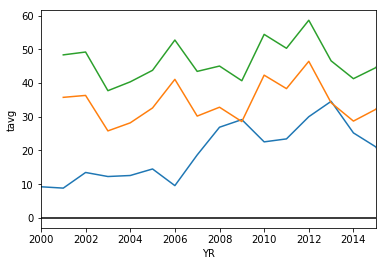

In [1198]:
x1 = massnh_df[massnh_df['FIPS'].isin(fips_1)].groupby("YR", as_index=False).Cases.sum()
x2 = massnh_df[massnh_df['FIPS'].isin(fips_2)].groupby("YR", as_index=False).Cases.sum()

t1 = massnh_df[massnh_df['FIPS'].isin(fips_1)].groupby("YR", as_index=False).tavg.mean()
t2 = massnh_df[massnh_df['FIPS'].isin(fips_2)].groupby("YR", as_index=False).tavg.mean()

massnh_df[massnh_df['FIPS'].isin(fips_2)]['lat'].mean() ,massnh_df[massnh_df['FIPS'].isin(fips_2)]['lat'].std()
massnh_df[massnh_df['FIPS'].isin(fips_1)]['lat'].mean() ,massnh_df[massnh_df['FIPS'].isin(fips_1)]['lat'].std()
massnh_df[massnh_df['FIPS'].isin(fips_1)]['Forest & Woodland'].mean()
massnh_df[massnh_df['FIPS'].isin(fips_2)]['Forest & Woodland'].mean()
massnh_df[massnh_df['FIPS'].isin(fips_2)]['lat'].mean()

sns.lineplot(x1.YR, x1.Cases/50)
sns.lineplot(x1.YR[1:], (t1.tavg-40)*5 )
sns.lineplot(x2.YR[1:], (t2.tavg-40)*5 )
plt.axhline(0.0, color='black')

plt.xlim(2000,2015)

In [ ]:
temp = massnh_df[massnh_df['FIPS']==fip]
years = temp[['YR']].values[:15]
cases = temp[['Cases']].values[:15]/np.mean(temp[['Cases']].values)
lat = temp.lat.values[0]

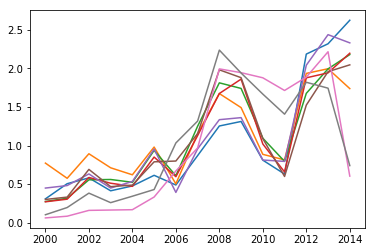

In [1239]:
years = []
cases = []

for fip in fips_2:
    temp = massnh_df[massnh_df['FIPS']==fip]
    years = temp[['YR']].values[:15]
    cases = temp[['Cases']].values[:15]/np.mean(temp[['Cases']].values)
    lat = temp.lat.values[0]
    plt.plot(years, cases)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
The current mse is 16314.2579778.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Starting forward filtering...
Forward filtering completed.
The new mse is 15868.6834168.


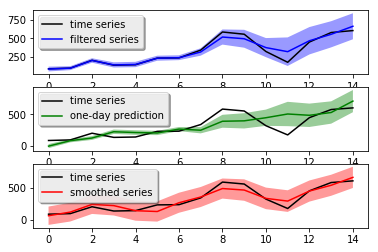

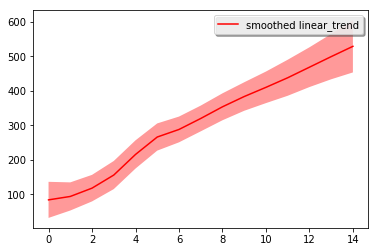

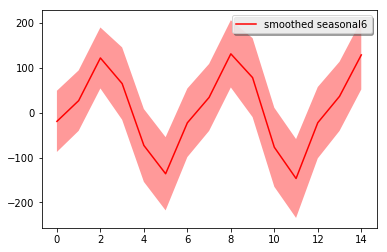

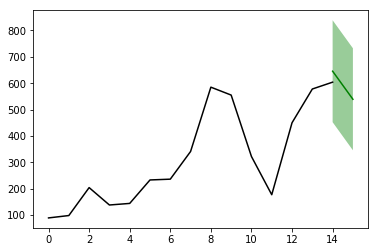

In [1243]:
from pydlm import dlm, trend, seasonality, autoReg
# A linear trend
linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)

# A seasonality
seasonal6 = seasonality(period=6, discount=0.99, name='seasonal6', w=10)

# Build a simple dlm
simple_dlm = dlm(time_series) + linear_trend + seasonal6

# Fit the model
simple_dlm.fit()
simple_dlm.tune()
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

simple_dlm.getMSE()

# Plot each component (attribute the time series to each component)
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal6')

# Plot the prediction give the first 351 weeks and forcast the next 200 weeks.
simple_dlm.plotPredictN(date=14, N=2)
simple_dlm.predictN(date=14, N=2)

autoReg(degree=3, discount=0.99, name='ar3', w=1e7)

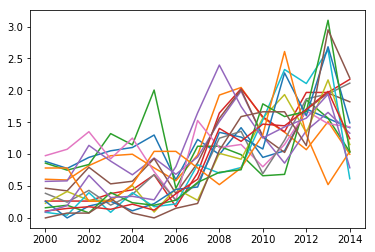

In [1238]:
years = []
cases = []

for fip in fips_1:
    temp = massnh_df[massnh_df['FIPS']==fip]
    years = temp[['YR']].values[:15]
    cases = temp[['Cases']].values[:15]/np.mean(temp[['Cases']].values)
    lat = temp.lat.values[0]
    plt.plot(years, cases)

In [922]:
ax = sns.lineplot(x="timepoint", y="signal",
             hue="event", style="event", data=fmri)

['25001',
 '25003',
 '25007',
 '25011',
 '25013',
 '25015',
 '25019',
 '25025',
 '33001',
 '33003',
 '33005',
 '33007',
 '33009',
 '33019']

In [887]:
lats = []

for state in ['New York', 'Massachusetts', 'Pennsylvania', 'Connecticut', 'Michigan', 'Maine', 'New Hampshire', 'Vermont']:
    
    state_df = inpdf[inpdf['Stname']==state]
    fips_state = state_df.FIPS.unique()
    for fip in fips_state:
        temp = state_df[state_df['FIPS']==fip]
        lats.append(temp['lat'].values[0])
        
lats_array = np.linspace(np.min(lats), np.max(lats),10)

In [888]:
for i in range(len(lats_array)-1):
    plot_values = []
    temp_df = val_df[(val_df['lat'] >= lats_array[i] ) & (val_df['lat'] <= lats_array[i+1])]
    fips = temp_df.FIPS.unique()
    temp_plot =[]
    
    for fip in fips:
        temp = temp_df[temp_df['FIPS']==fip]
        years = temp[['YR']].values
        cases = temp[['Cases']].values
        temp_plot.append([years,cases])

In [891]:
for i in range(len(lats_array)-1):
    
    plot_values = []
    temp_df = val_df[(val_df['lat'] >= lats_array[i] ) & (val_df['lat'] <= lats_array[i+1])]
    fips = temp_df.FIPS.unique()
    print(len(fips))

    temps = []

    slopes = []
    lats = []

    shrubs = []
    forests = []
    yrs = []

    diff_model = []
    diff_baseline = []

    temp_plot =[]
    for fip in fips:
        temp = temp_df[temp_df['FIPS']==fip]
        years = temp[['YR']].values[8:-2]
        cases = temp[['Cases']].values[8:-2]

        cases_val = temp[['Cases']].values[-2:]
        year_val = temp[['YR']].values[-2:]

        baseline = cases[-1]
        reg = LinearRegression().fit(years,cases)  
        diff_model.append(abs(reg.predict(year_val).reshape(2) - np.array(cases_val).reshape(2)))
        diff_baseline.append(abs(baseline - np.array(cases_val)).reshape(2))
        temp_plot.append([years,cases])
        
    rms_model_yr1, rms_baseline_yr1 = sum([x[0]**2 for x in diff_model])**0.5, sum([x[0]**2 for x in diff_baseline])**0.5
    rms_model_yr2, rms_baseline_yr2 = sum([x[1]**2 for x in diff_model])**0.5, sum([x[1]**2 for x in diff_baseline])**0.5

    print(lats_array[i],lats_array[i+1], temp_df.Stname.mode().values,rms_model_yr1, rms_baseline_yr1, rms_model_yr2, rms_baseline_yr2)

40
39.852 40.7161111111 ['Pennsylvania'] 607.161384171 546.321334015 856.14561871 731.982240222
45
40.7161111111 41.5802222222 ['Pennsylvania'] 443.251422987 483.027949502 658.370760905 499.220392212
49
41.5802222222 42.4443333333 ['New York'] 1342.79589336 1176.2066145 1443.51924489 1138.62856103
54
42.4443333333 43.3084444444 ['New York'] 932.495209814 781.599002046 1077.6172212 829.40882561
37
43.3084444444 44.1725555556 ['Michigan'] 74.3039469383 99.6092365195 123.605678114 179.563359291
36
44.1725555556 45.0366666667 ['Michigan'] 41.1790825145 85.5978971704 174.031872211 249.202728717
8
45.0366666667 45.9007777778 ['Michigan'] 35.4462621443 39.7114593033 88.0850227346 99.9649938729
13
45.9007777778 46.7648888889 ['Michigan'] 13.147417687 21.1896201004 41.597498712 51.0
2
46.7648888889 47.629 ['Michigan'] 2.18325024508 2.0 3.05973225156 3.0


In [892]:
len(diff_model)

2

In [873]:
## do it based on latitude bins

mass_df = inpdf[inpdf['Stname']=='Massachusetts']

fips_mass = mass_df.FIPS.unique()

temps = []

slopes = []
lats = []

shrubs = []
forests = []
yrs = []

diff_model = []
diff_baseline = []

for fip in fips_mass:
    temp = mass_df[mass_df['FIPS']==fip]
    years = temp[['YR']].values[5:-5]
    cases = temp[['Cases']].values[5:-5]

    cases_val = temp[['Cases']].values[-5:-3]
    year_val = temp[['YR']].values[-5:-3]

    baseline = cases[-1]
    reg = LinearRegression().fit(years,cases)  
#    diff_model.append(abs(reg.predict(year_val) - cases_val))
#    diff_baseline.append(abs(baseline - cases_val))

    diff_model.append(abs(reg.predict(year_val).reshape(2) - np.array(cases_val).reshape(2)))
    diff_baseline.append(abs(baseline - np.array(cases_val)).reshape(2))

rms_model_yr1, rms_baseline_yr1 = sum([x[0]**2 for x in diff_model])**0.5, sum([x[0]**2 for x in diff_baseline])**0.5
rms_model_yr2, rms_baseline_yr2 = sum([x[1]**2 for x in diff_model])**0.5, sum([x[1]**2 for x in diff_baseline])**0.5

print(rms_model_yr1, rms_baseline_yr1, rms_model_yr2, rms_baseline_yr2)

454.582902006 249.282971741 467.103594201 340.731565899


In [879]:
dlm_fit =[]
preds = []
y_ypred_rms = []
rmss = []
mses = []

diff_model = []
diff_baseline = []

for fip in fips_mass:
    temp = mass_df[mass_df['FIPS']==fip]
    years = temp[['YR']].values[5:-5]
    cases = temp[['Cases']].values[5:-5]
    years_val =  temp[['YR']].values[-5:-3]
    cases_val =  temp[['Cases']].values[-5:-3]
    baseline = temp[['Cases']].values[-6]

    pred, mse, model = fitdlm(cases, label=0)

    diff_model.append(abs(np.array(pred[0]).reshape(2) - np.array(cases_val).reshape(2)))
    diff_baseline.append(abs(baseline - np.array(cases_val)).reshape(2))
    
rms_model_yr1, rms_baseline_yr1 = sum([x[0]**2 for x in diff_model])**0.5, sum([x[0]**2 for x in diff_baseline])**0.5
rms_model_yr2, rms_baseline_yr2 = sum([x[1]**2 for x in diff_model])**0.5, sum([x[1]**2 for x in diff_baseline])**0.5

print(rms_model_yr1, rms_baseline_yr1, rms_model_yr2, rms_baseline_yr2)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
The current mse is 19382.38408.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Starting forward filtering...
Forward filtering completed.
The new mse is 19304.4692717.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
The current mse is 3058.59402567.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Starting forward filtering...
Forward filtering completed.
The new mse is 3328.75040906.
Initializing mod

334.766079343 249.282971741 274.457227665 340.731565899


In [ ]:
lats_massnh = []
tstates = ['Massachusetts', 'New Hampshire']
massnh_df = inpdf[inpdf['Stname'].isin(tstates)]

fips_massnh = massnh_df.FIPS.unique()

slopes = []
fips_1 = []
fips_2 = []
cm = plt.cm.get_cmap('RdYlBu')

for fip in fips_massnh:
    temp = massnh_df[massnh_df['FIPS']==fip]
    lats_massnh.append(temp['lat'].values[0])
    years = temp[['YR']].values[:14]
    cases = temp[['Cases']].values[:14]
    lat = temp.lat.values[0]
    plt.plot(years, cases)
    reg = LinearRegression().fit(years,cases)  
    if reg.coef_ < 17:
        fips_1.append(fip)
    else:
        fips_2.append(fip)
        
        plt.plot(massnh_df[massnh_df['FIPS'].isin(fips_1)].groupby('YR').tavg.mean(), color='red')
plt.plot(massnh_df[massnh_df['FIPS'].isin(fips_2)].groupby('YR').tavg.mean(), color='black')

x1 = massnh_df[massnh_df['FIPS'].isin(fips_1)].groupby('YR').Cases.mean()/8 + 45
x2 = massnh_df[massnh_df['FIPS'].isin(fips_2)].groupby('YR').Cases.mean()/8 + 45

plt.plot(x1, color='blue')
plt.plot(x2, color='green')


In [851]:
dlm_fit =[]
i = 0 

preds = []
y_ypred_rms = []
rmss = []
mses = []

diff_model = []
diff_baseline = []

for fip in fips_mass:
    temp = mass_df[mass_df['FIPS']==fip]
    years = temp[['YR']].values[5:-5]
    cases = temp[['Cases']].values[5:-5]
    years_test =  temp[['YR']].values[-5:-3]
    cases_test =  temp[['Cases']].values[-5:-3]
    baseline = temp[['Cases']].values[-6]

    pred, mse, model = fitdlm(cases, label=0)

    diff_model.append(abs(np.array(pred[0]).reshape(2) - np.array(cases_test).reshape(2)))
    diff_baseline.append(abs(baseline - np.array(cases_test)).reshape(2))

rms_model_yr1, rms_baseline_yr1 = sum([x[0]**2 for x in diff_model])**0.5, sum([x[0]**2 for x in diff_baseline])**0.5
rms_model_yr2, rms_baseline_yr2 = sum([x[1]**2 for x in diff_model])**0.5, sum([x[1]**2 for x in diff_baseline])**0.5

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
The current mse is 19382.38408.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Starting forward filtering...
Forward filtering completed.
The new mse is 19304.4692717.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
The current mse is 3058.59402567.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Starting forward filtering...
Forward filtering completed.
The new mse is 3328.75040906.
Initializing mod

In [855]:
print(rms_model_yr1, rms_baseline_yr1, rms_model_yr2, rms_baseline_yr2)

334.766079343 249.282971741 274.457227665 340.731565899


In [629]:
newvar_arr = np.array([np.array(xi) for xi in newvar])

In [566]:
## Doing a time series prediction 

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
The current mse is 16314.2579778.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Starting forward filtering...
Forward filtering completed.
The new mse is 15868.6834168.


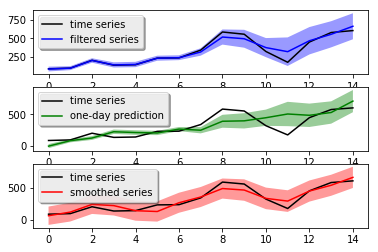

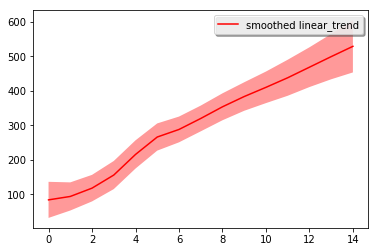

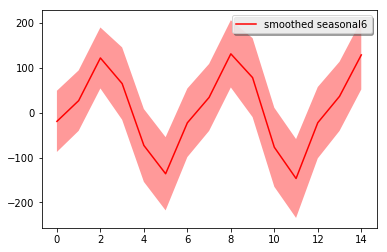

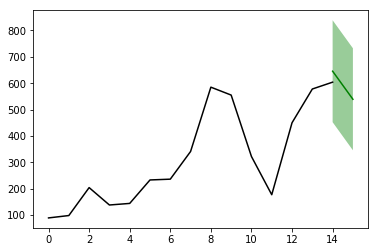

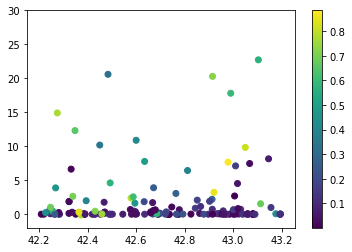

In [442]:
slopes = []
lats = []
forests = []

for fip in inpdf['FIPS'].unique():
    if  42.2 < inpdf[inpdf['FIPS']==fip]['lat'].values[0] < 43.2: 
        temp = inpdf[inpdf['FIPS']==fip]
    
        years = temp[['YR']].values
        cases = temp[['Cases']].values

        reg = LinearRegression().fit(years,cases)
        slopes.append(reg.coef_)
        lats.append(temp.lat.values[0])
        forests.append(temp['Forest & Woodland'].values[0])
        plt.plot(years, reg.predict(years), color='black')
        plt.plot(years,cases)

        
mass_df = inpdf[inpdf['Stname']=='Massachusetts']

fips_mass = mass_df.FIPS.unique()

slopes = []
lats = []
for fip in fips_mass:
    
    temp = mass_df[mass_df['FIPS']==fip]
    years = temp[['YR']].values
    cases = temp[['Cases']].values
    
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_)
    lats.append(temp.lat.values[0])
    plt.plot(years,  reg.predict(years), color='black')
    plt.plot(years,cases)

    
    plt.scatter(lats,slopes)

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   15
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -90.703
Method:                       css-mle   S.D. of innovations             99.443
Date:                Mon, 17 Jun 2019   AIC                            189.407
Time:                        22:30:00   BIC                            192.239
Sample:                             1   HQIC                           189.377
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0311     19.885      1.510      0.157      -8.942      69.005
ar.L1.D.y      0.2248      0.202      1.111      0.288      -0.172       0.621
ar.L2.D.y     -0.5830      0.185     -3.150      0.0

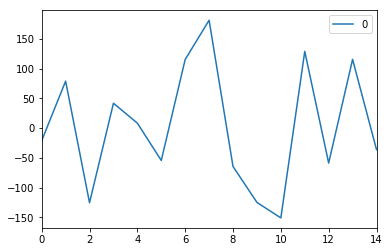

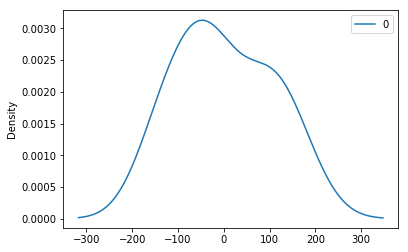

                0
count   15.000000
mean     2.334269
std    103.691738
min   -150.907511
25%    -61.547575
50%    -21.031145
75%     97.187703
max    181.360992


In [253]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
series = inpdf[inpdf['YR']<=2015][inpdf['FIPS']==fip][['Cases']].values
# fit model

model = ARIMA(series, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [251]:
conf_int = model_fit.conf_int()
conf_int

array([[ -8.942339  ,  69.00462909],
       [ -0.17157893,   0.6210991 ],
       [ -0.94563113,  -0.22027264]])

predicted=468.729526, expected=322.000000
predicted=183.990644, expected=177.000000
predicted=180.108986, expected=450.000000
predicted=595.105946, expected=578.000000
predicted=398.042376, expected=604.000000
predicted=501.620222, expected=540.000000
Test MSE: 23100.624


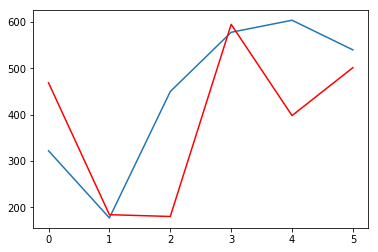

In [275]:
X = series
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(3,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [317]:
series = inpdf[inpdf['YR']<=2016][inpdf['FIPS']==fip][['Cases']]
train = inpdf[inpdf['YR']<2016][inpdf['FIPS']==fip][['Cases']]
test = inpdf[inpdf['YR']==2016][inpdf['FIPS']==fip][['Cases']]

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [318]:
from pyramid.arima import auto_arima

stepwise_model = auto_arima(series, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=2, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())


Fit ARIMA: order=(1, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0); AIC=206.112, BIC=207.528, Fit time=0.007 seconds
Fit ARIMA: order=(1, 2, 0); AIC=208.107, BIC=210.232, Fit time=0.105 seconds
Fit ARIMA: order=(0, 2, 1); AIC=208.091, BIC=210.216, Fit time=0.035 seconds
Total fit time: 0.174 seconds
206.112162701


In [319]:
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=1)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
forecasted = pd.concat([test,future_forecast],axis=1)

In [321]:
forecasted

Cases  Prediction
21256     10  470.785714

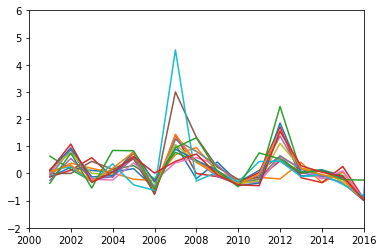

In [446]:
mass_df = inpdf[inpdf['Stname']=='Massachusetts']

fips_mass = mass_df.FIPS.unique()

slopes = []
lats = []
for fip in fips_mass:
    
    temp = mass_df[mass_df['FIPS']==fip]
    years = temp[['YR']].values[1:]
    cases = temp[['Cases']].pct_change()[1:]
    
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_)
    lats.append(temp.lat.values[0])
    plt.plot(years,cases)
    #plt.plot(years, reg.predict(years))
    plt.xlim(2000,2016)
    plt.ylim(-2,6)

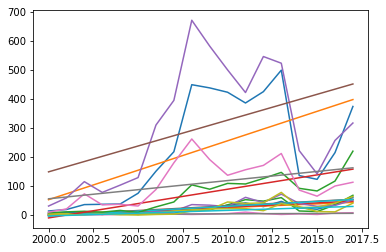

In [427]:
nh_df = inpdf[inpdf['Stname']=='New Hampshire']

fips_nh = nh_df.FIPS.unique()

slopes = []
lats = []
for fip in fips_nh:
    
    temp = nh_df[nh_df['FIPS']==fip]
    years = temp[['YR']].values
    cases = temp[['Cases']].values
    
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_)
    lats.append(temp.lat.values[0])
    plt.plot(years,cases)
    plt.plot(years,  reg.predict(years))

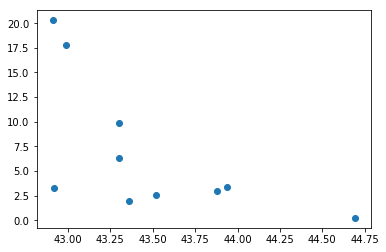

In [428]:
plt.scatter(lats, slopes)

In [411]:
temp[['Cases']]

Cases
FIPS        
33005      7
33005      0
33005      5
33005      7
33005      3
33005      6
33005     12
33005     13
33005     36
33005     34
33005     29
33005     61
33005     43
33005     72
33005     40
33005     30
33005     33
33005     52

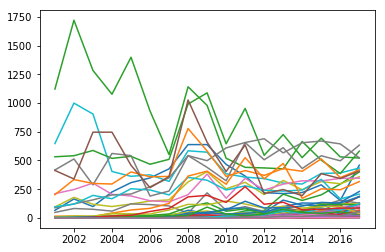

In [749]:
ny_df = inpdf[inpdf['Stname']=='New York']

fips_ny = ny_df.FIPS.unique()

temps = []
yrs = []

slopes = []
lats = []

for fip in fips_ny:
    temp = ny_df[ny_df['FIPS']==fip]
    temps = temp.Cases[1:]
    years  = temp['YR'].values[1:]
    
    slopes.append(slope)
    lats.append(temp.lat.values[0])
    
    plt.plot(years,temps)

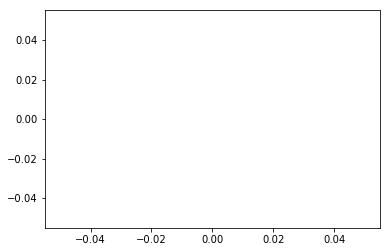

In [422]:
plt.scatter(lats,slopes)

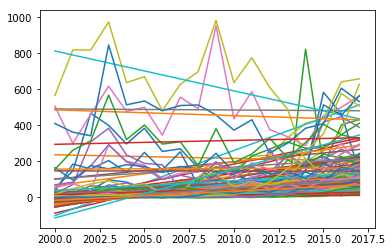

In [177]:
penn_df = inpdf[inpdf['Stname']=='Pennsylvania']

fips_penn = penn_df.FIPS.unique()

temps = []

slopes = []
lats = []

yrs = []
for fip in fips_penn:
    temp = penn_df[penn_df['FIPS']==fip]
    years = temp[['YR']].values
    cases = temp[['Cases']].values
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_)
    lats.append(temp.lat.values[0])
    forests.append(temp['Forest & Woodland'].values[0])
    shrubs.append(temp['Shrub & Herb Vegetation'].values[0])
  
    plt.plot(years,cases)
    plt.plot(years,reg.predict(years))

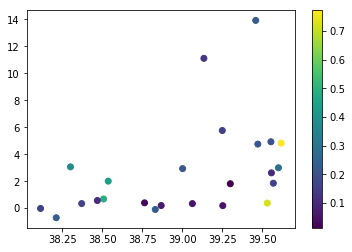

In [399]:
plt.scatter(lats,slopes, c=forests)
plt.colorbar()

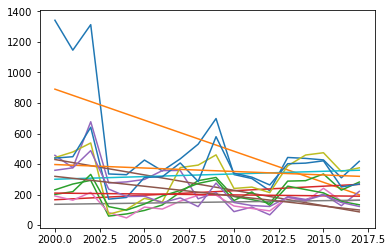

In [181]:
conn_df = inpdf[inpdf['Stname']=='Connecticut']

fips_conn = conn_df.FIPS.unique()

temps = []

slopes = []
lats = []

yrs = []
for fip in fips_conn:
    temp = conn_df[conn_df['FIPS']==fip]
    years = temp[['YR']].values
    cases = temp[['Cases']].values
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_)
    lats.append(temp.lat.values[0])
    forests.append(temp['Forest & Woodland'].values[0])
    shrubs.append(temp['Shrub & Herb Vegetation'].values[0])
  
    plt.plot(years,cases)
    plt.plot(years,reg.predict(years))

In [420]:
verm_df = inpdf[inpdf['Stname']=='Vermont']

fips_verm = verm_df.FIPS.unique()

temps = []

slopes = []
lats = []

forests = []

yrs = []
for fip in fips_verm:
    temp = verm_df[verm_df['FIPS']==fip]
    years = temp[['YR']].values[1:]
    cases = temp[['Cases']].pct_change()[1:]
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_)
    lats.append(temp.lat.values[0])
    forests.append(temp['Forest & Woodland'].values[0])
    shrubs.append(temp['Shrub & Herb Vegetation'].values[0])
  
    plt.plot(years,cases)
    plt.plot(years,reg.predict(years))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

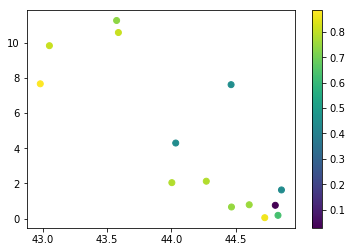

In [212]:
plt.scatter(lats,slopes, c=forests)
plt.colorbar()

[[ 6.21421215]] 44.173
[[ 0.1915551]] 46.66
[[ 21.39546859]] 43.848
[[ 0.84243048]] 44.968
[[ 10.1246138]] 44.662
[[ 14.42739444]] 44.401
[[ 8.60659114]] 44.157
[[ 5.50978373]] 44.053
[[ 3.09989701]] 44.494
[[ 5.06488157]] 45.4
[[ 0.23377961]] 45.839
[[ 4.73532441]] 43.96
[[ 2.76725026]] 45.51
[[ 6.21318229]] 44.5
[[ 1.44696189]] 45.032
[[ 9.76519053]] 43.48


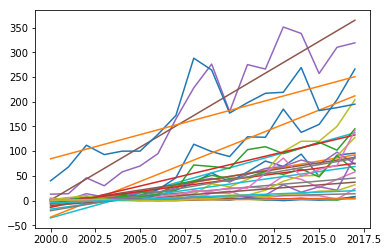

In [1065]:
maine_df = inpdf[inpdf['Stname']=='Maine']

fips_maine = maine_df.FIPS.unique()

temps = []

slopes = []
lats = []

shrubs = []
forests = []
yrs = []

regs = []
for fip in fips_maine:
    temp = maine_df[maine_df['FIPS']==fip]
    years = temp[['YR']].values
    cases = temp[['Cases']].values
    #reg = LinearRegression().fit(years,cases)
    reg = Ridge().fit(years,cases)
    slopes.append(reg.coef_)
    lats.append(temp.lat.values[0])
    forests.append(temp['Forest & Woodland'].values[0])
    shrubs.append(temp['Shrub & Herb Vegetation'].values[0])
  
    plt.plot(years,cases)
    plt.plot(years,reg.predict(years))
    
    regs.append(reg.coef_)
    print(reg.coef_,temp.lat.values[0] )

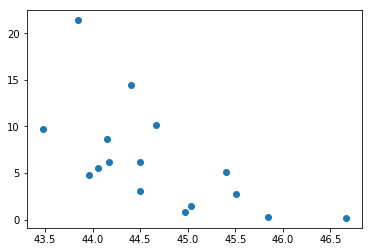

In [1066]:
plt.scatter(lats,[x[0][0] for x in regs])

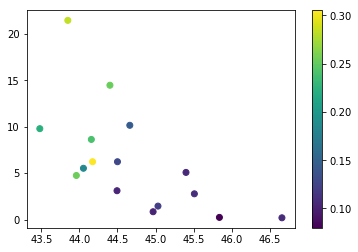

In [209]:
plt.scatter(lats,slopes, c=shrubs)
plt.colorbar()

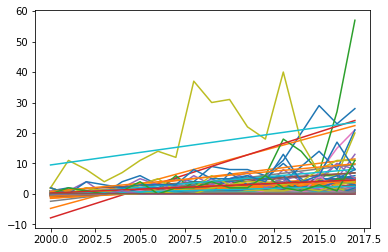

In [204]:
mich_df = inpdf[inpdf['Stname']=='Michigan']

fips_mich = mich_df.FIPS.unique()

temps = []

slopes = []
lats = []

forests = []
yrs = []
for fip in fips_mich:
    temp = mich_df[mich_df['FIPS']==fip]
    years = temp[['YR']].values
    cases = temp[['Cases']].values
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_)
    lats.append(temp.lat.values[0])
    forests.append(temp['Forest & Woodland'].values[0])
    shrubs.append(temp['Shrub & Herb Vegetation'].values[0])
  
    plt.plot(years,cases)
    plt.plot(years,reg.predict(years))

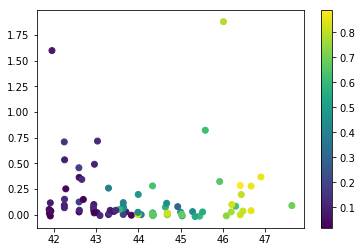

In [205]:
plt.scatter(lats,slopes, c=forests)
plt.colorbar()

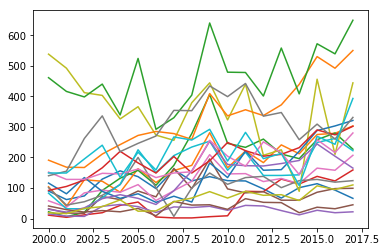

In [394]:
nj_df = inpdf[inpdf['Stname']=='New Jersey']

fips_nj = nj_df.FIPS.unique()

temps = []
yrs = []
for fip in fips_nj:
    temp = nj_df[nj_df['FIPS']==fip]
    temps = temp.Cases.values
    years  = temp['YR'].values
    plt.plot(years,temps)

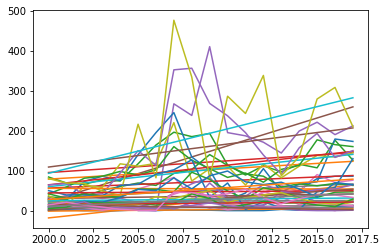

In [397]:
md_df = inpdf[inpdf['Stname']=='Maryland']

fips_md = md_df.FIPS.unique()

temps = []

slopes = []
lats = []

forests = []
yrs = []
for fip in fips_md:
    temp = md_df[md_df['FIPS']==fip]
    years = temp[['YR']].values
    cases = temp[['Cases']].values
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_)
    lats.append(temp.lat.values[0])
    forests.append(temp['Forest & Woodland'].values[0])
    shrubs.append(temp['Shrub & Herb Vegetation'].values[0])
  
    plt.plot(years,cases)
    plt.plot(years,reg.predict(years))

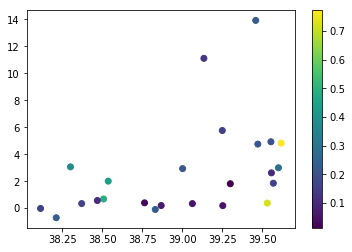

In [398]:
plt.scatter(lats,slopes, c=forests)
plt.colorbar()

In [31]:
error_baseline = []
error_model= []
error_model_rf= []

for fip in fips_mass:
    temp = mass_df[mass_df['FIPS']==fip]
    temp_train = temp[temp['YR']<2015]
    temp_test = temp[temp['YR']==2015]
    X_train = temp_train[['YR']].values
    y_train = temp_train[['Cases']].values
    
    X_test = temp_test[['YR']].values
    y_test = temp_test[['Cases']].values
    
    reg = LinearRegression().fit(X_train, y_train)
    
    model = RandomForestRegressor(n_estimators=10, max_features=2)
    model.fit(X_train, y_train.ravel())

    y_pred = reg.predict(X_test)
    #y_pred_rf = model.predict(X_test)
    #score_model = np.sum(np.abs(y_train - reg.predict(X_train))/len(y_train))
    #print(reg.)
    error_baseline.append(np.sum(((y_test - temp[temp['year']==2014]['Cases'].values))**2)**0.5 /len(y_train))
    error_model.append(np.sum(((y_test - y_pred))**2)**0.5)
    error_model.append(np.sum(((y_test - y_pred))**2)**0.5)
    #error_model_rf.append(np.sum(((y_test - y_pred_rf))**2)**0.5)
    #y_pred = reg.predict(X_test)

    

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

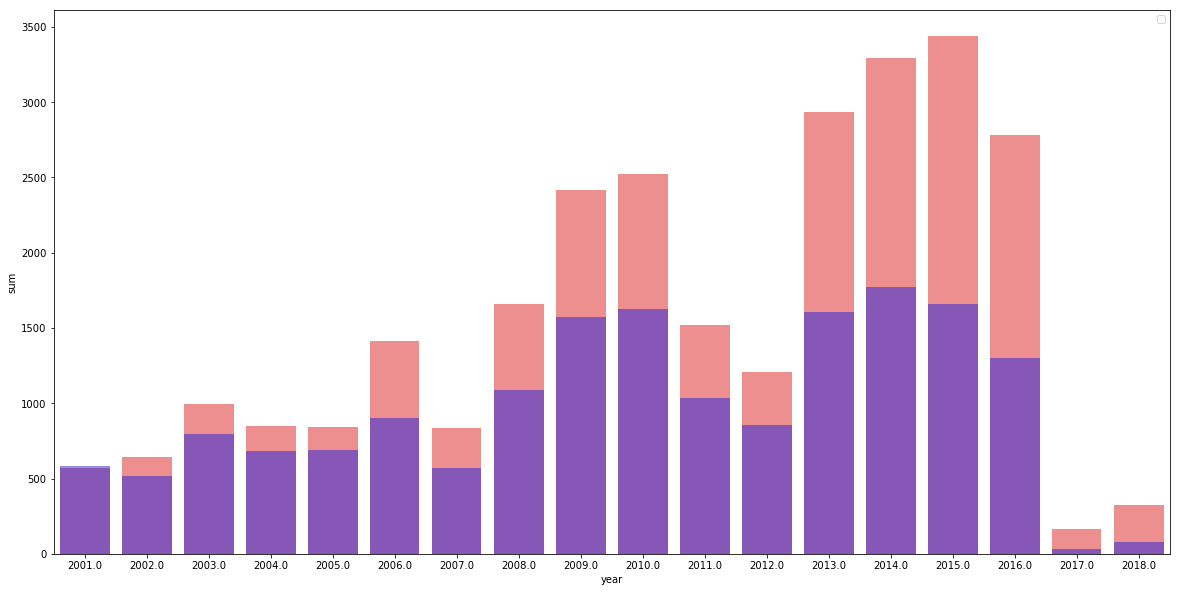

In [26]:
temp = inpdf[inpdf['Stname']=='Massachusetts']

temp['pcpn_1']= temp[['JAN_PCPN', 'FEB_PCPN', 'MAR_PCPN', 'APR_PCPN']].mean(axis=1)
temp['pcpn_2']= temp[['MAY_PCPN', 'JUN_PCPN', 'JUL_PCPN', 'AUG_PCPN']].mean(axis=1)
temp['pcpn_3']= temp[['SEP_PCPN', 'OCT_PCPN', 'NOV_PCPN', 'DEC_PCPN']].mean(axis=1)

temp['tmpc_1']= temp[['JAN_TMPC', 'FEB_TMPC', 'MAR_TMPC', 'APR_TMPC']].mean(axis=1)
temp['tmpc_2']= temp[['MAY_TMPC', 'JUN_TMPC', 'JUL_TMPC', 'AUG_TMPC']].mean(axis=1)
temp['tmpc_3']= temp[['SEP_TMPC', 'OCT_TMPC', 'NOV_TMPC', 'DEC_TMPC']].mean(axis=1)

temp['tmax_1']= temp[['JAN_TMAX', 'FEB_TMAX', 'MAR_TMAX', 'APR_TMAX']].mean(axis=1)
temp['tmax_2']= temp[['MAY_TMAX', 'JUN_TMAX', 'JUL_TMAX', 'AUG_TMAX']].mean(axis=1)
temp['tmax_3']= temp[['SEP_TMAX', 'OCT_TMAX', 'NOV_TMAX', 'DEC_TMAX']].mean(axis=1)

temp['tmin_1']= temp[['JAN_TMIN', 'FEB_TMIN', 'MAR_TMIN', 'APR_TMIN']].mean(axis=1)
temp['tmin_2']= temp[['MAY_TMIN', 'JUN_TMIN', 'JUL_TMIN', 'AUG_TMIN']].mean(axis=1)
temp['tmin_3']= temp[['SEP_TMIN', 'OCT_TMIN', 'NOV_TMIN', 'DEC_TMIN']].mean(axis=1)

new_temp = temp.groupby("Ctyname", as_index=False).tmpc_2.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
med = np.median(new_temp['mean'])

warmc = new_temp[new_temp['mean']>med]['Ctyname']
coolc = new_temp[new_temp['mean']<=med]['Ctyname']

warmc_time = temp.loc[temp['Ctyname'].isin(warmc)]
coolc_time = temp.loc[temp['Ctyname'].isin(coolc)]

x1_mean = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
x1_sum = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})
x1_rms = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "std": "std"})

x2_mean = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
x2_sum = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})
x2_rms = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "std": "std"})

plt.figure(figsize=(20,10))
sns.barplot(x1_mean['year'], x1_sum['sum'], color='red', alpha=0.5)
sns.barplot(x2_mean['year']+1.0, x2_sum['sum'], color='blue', alpha=0.5)
plt.legend('Warm counties', 'Cool counties')

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

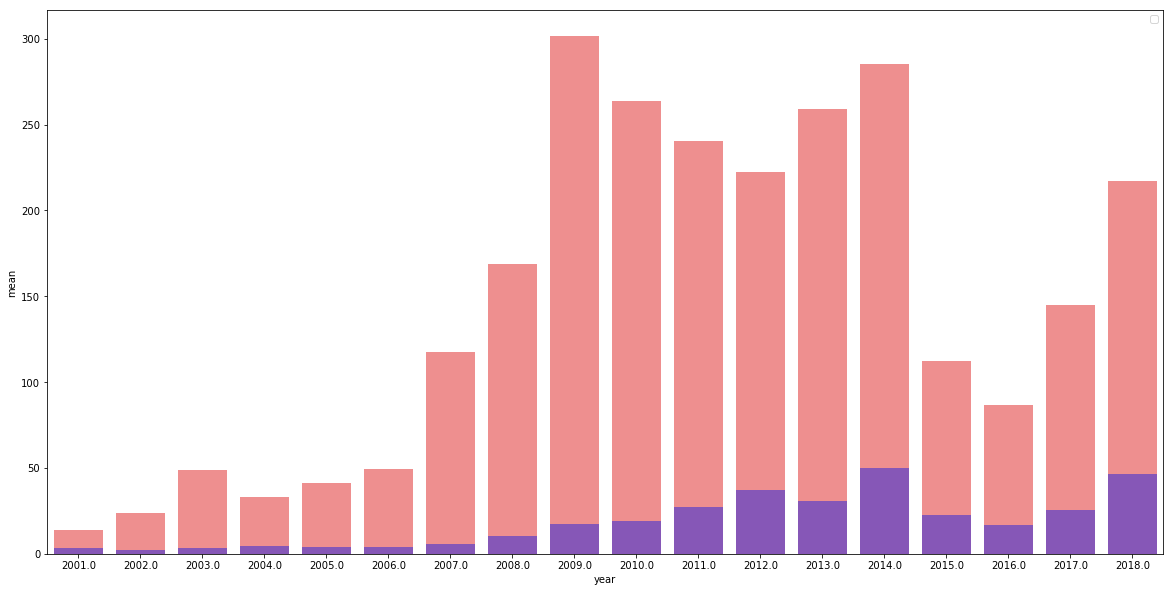

In [14]:
temp = inpdf[inpdf['Stname']=='New Hampshire']

temp['pcpn_1']= temp[['JAN_PCPN', 'FEB_PCPN', 'MAR_PCPN', 'APR_PCPN']].mean(axis=1)
temp['pcpn_2']= temp[['MAY_PCPN', 'JUN_PCPN', 'JUL_PCPN', 'AUG_PCPN']].mean(axis=1)
temp['pcpn_3']= temp[['SEP_PCPN', 'OCT_PCPN', 'NOV_PCPN', 'DEC_PCPN']].mean(axis=1)

temp['tmpc_1']= temp[['JAN_TMPC', 'FEB_TMPC', 'MAR_TMPC', 'APR_TMPC']].mean(axis=1)
temp['tmpc_2']= temp[['MAY_TMPC', 'JUN_TMPC', 'JUL_TMPC', 'AUG_TMPC']].mean(axis=1)
temp['tmpc_3']= temp[['SEP_TMPC', 'OCT_TMPC', 'NOV_TMPC', 'DEC_TMPC']].mean(axis=1)

temp['tmax_1']= temp[['JAN_TMAX', 'FEB_TMAX', 'MAR_TMAX', 'APR_TMAX']].mean(axis=1)
temp['tmax_2']= temp[['MAY_TMAX', 'JUN_TMAX', 'JUL_TMAX', 'AUG_TMAX']].mean(axis=1)
temp['tmax_3']= temp[['SEP_TMAX', 'OCT_TMAX', 'NOV_TMAX', 'DEC_TMAX']].mean(axis=1)

temp['tmin_1']= temp[['JAN_TMIN', 'FEB_TMIN', 'MAR_TMIN', 'APR_TMIN']].mean(axis=1)
temp['tmin_2']= temp[['MAY_TMIN', 'JUN_TMIN', 'JUL_TMIN', 'AUG_TMIN']].mean(axis=1)
temp['tmin_3']= temp[['SEP_TMIN', 'OCT_TMIN', 'NOV_TMIN', 'DEC_TMIN']].mean(axis=1)

new_temp = temp.groupby("Ctyname", as_index=False).tmpc_2.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
med = np.median(new_temp['mean'])

warmc = new_temp[new_temp['mean']>med]['Ctyname']
coolc = new_temp[new_temp['mean']<=med]['Ctyname']

warmc_time = temp.loc[temp['Ctyname'].isin(warmc)]
coolc_time = temp.loc[temp['Ctyname'].isin(coolc)]

x1_mean = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
x1_sum = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})
x1_rms = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "std": "std"})

x2_mean = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
x2_sum = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})
x2_rms = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "std": "std"})

plt.figure(figsize=(20,10))
sns.barplot(x1_mean['year'], x1_mean['mean'], color='red', alpha=0.5)
sns.barplot(x2_mean['year']+1.0, x2_mean['mean'], color='blue', alpha=0.5)
plt.legend('Warm counties', 'Cool counties')

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

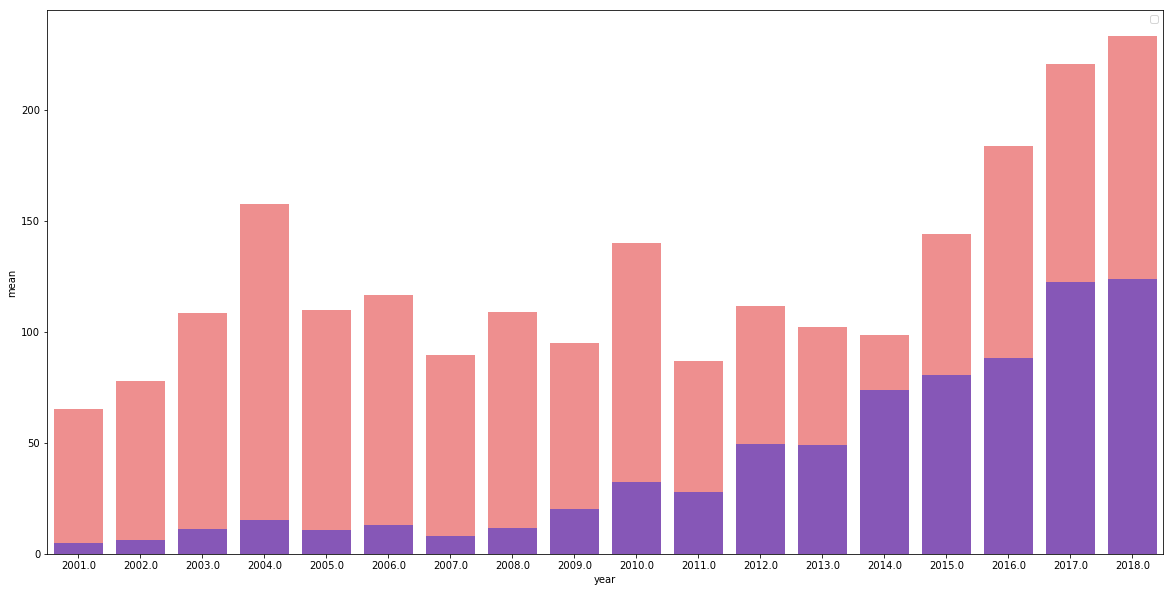

In [16]:
temp = inpdf[inpdf['Stname']=='Pennsylvania']

temp['pcpn_1']= temp[['JAN_PCPN', 'FEB_PCPN', 'MAR_PCPN', 'APR_PCPN']].mean(axis=1)
temp['pcpn_2']= temp[['MAY_PCPN', 'JUN_PCPN', 'JUL_PCPN', 'AUG_PCPN']].mean(axis=1)
temp['pcpn_3']= temp[['SEP_PCPN', 'OCT_PCPN', 'NOV_PCPN', 'DEC_PCPN']].mean(axis=1)

temp['tmpc_1']= temp[['JAN_TMPC', 'FEB_TMPC', 'MAR_TMPC', 'APR_TMPC']].mean(axis=1)
temp['tmpc_2']= temp[['MAY_TMPC', 'JUN_TMPC', 'JUL_TMPC', 'AUG_TMPC']].mean(axis=1)
temp['tmpc_3']= temp[['SEP_TMPC', 'OCT_TMPC', 'NOV_TMPC', 'DEC_TMPC']].mean(axis=1)

temp['tmax_1']= temp[['JAN_TMAX', 'FEB_TMAX', 'MAR_TMAX', 'APR_TMAX']].mean(axis=1)
temp['tmax_2']= temp[['MAY_TMAX', 'JUN_TMAX', 'JUL_TMAX', 'AUG_TMAX']].mean(axis=1)
temp['tmax_3']= temp[['SEP_TMAX', 'OCT_TMAX', 'NOV_TMAX', 'DEC_TMAX']].mean(axis=1)

temp['tmin_1']= temp[['JAN_TMIN', 'FEB_TMIN', 'MAR_TMIN', 'APR_TMIN']].mean(axis=1)
temp['tmin_2']= temp[['MAY_TMIN', 'JUN_TMIN', 'JUL_TMIN', 'AUG_TMIN']].mean(axis=1)
temp['tmin_3']= temp[['SEP_TMIN', 'OCT_TMIN', 'NOV_TMIN', 'DEC_TMIN']].mean(axis=1)

new_temp = temp.groupby("Ctyname", as_index=False).tmpc_2.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
med = np.median(new_temp['mean'])

warmc = new_temp[new_temp['mean']>med]['Ctyname']
coolc = new_temp[new_temp['mean']<=med]['Ctyname']

warmc_time = temp.loc[temp['Ctyname'].isin(warmc)]
coolc_time = temp.loc[temp['Ctyname'].isin(coolc)]

x1_mean = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
x1_sum = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})
x1_rms = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "std": "std"})

x2_mean = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
x2_sum = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})
x2_rms = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "std": "std"})

plt.figure(figsize=(20,10))
sns.barplot(x1_mean['year'], x1_mean['mean'], color='red', alpha=0.5)
sns.barplot(x2_mean['year']+1.0, x2_mean['mean'], color='blue', alpha=0.5)
plt.legend('Warm counties', 'Cool counties')

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

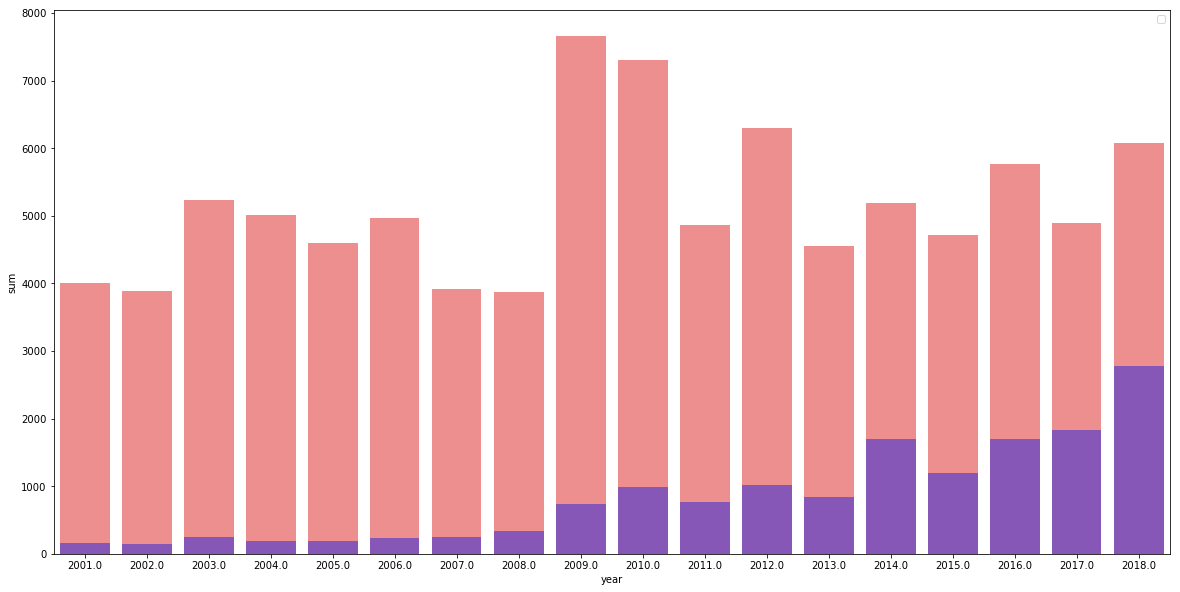

In [25]:
temp = inpdf[inpdf['Stname']=='New York']

temp['pcpn_1']= temp[['JAN_PCPN', 'FEB_PCPN', 'MAR_PCPN', 'APR_PCPN']].mean(axis=1)
temp['pcpn_2']= temp[['MAY_PCPN', 'JUN_PCPN', 'JUL_PCPN', 'AUG_PCPN']].mean(axis=1)
temp['pcpn_3']= temp[['SEP_PCPN', 'OCT_PCPN', 'NOV_PCPN', 'DEC_PCPN']].mean(axis=1)

temp['tmpc_1']= temp[['JAN_TMPC', 'FEB_TMPC', 'MAR_TMPC', 'APR_TMPC']].mean(axis=1)
temp['tmpc_2']= temp[['MAY_TMPC', 'JUN_TMPC', 'JUL_TMPC', 'AUG_TMPC']].mean(axis=1)
temp['tmpc_3']= temp[['SEP_TMPC', 'OCT_TMPC', 'NOV_TMPC', 'DEC_TMPC']].mean(axis=1)

temp['tmax_1']= temp[['JAN_TMAX', 'FEB_TMAX', 'MAR_TMAX', 'APR_TMAX']].mean(axis=1)
temp['tmax_2']= temp[['MAY_TMAX', 'JUN_TMAX', 'JUL_TMAX', 'AUG_TMAX']].mean(axis=1)
temp['tmax_3']= temp[['SEP_TMAX', 'OCT_TMAX', 'NOV_TMAX', 'DEC_TMAX']].mean(axis=1)

temp['tmin_1']= temp[['JAN_TMIN', 'FEB_TMIN', 'MAR_TMIN', 'APR_TMIN']].mean(axis=1)
temp['tmin_2']= temp[['MAY_TMIN', 'JUN_TMIN', 'JUL_TMIN', 'AUG_TMIN']].mean(axis=1)
temp['tmin_3']= temp[['SEP_TMIN', 'OCT_TMIN', 'NOV_TMIN', 'DEC_TMIN']].mean(axis=1)

new_temp = temp.groupby("Ctyname", as_index=False).tmpc_2.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
med = np.median(new_temp['mean'])

warmc = new_temp[new_temp['mean']>med]['Ctyname']
coolc = new_temp[new_temp['mean']<=med]['Ctyname']

warmc_time = temp.loc[temp['Ctyname'].isin(warmc)]
coolc_time = temp.loc[temp['Ctyname'].isin(coolc)]

x1_mean = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
x1_sum = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})
x1_rms = warmc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "std": "std"})

x2_mean = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "mean": "mean"})
x2_sum = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "sum": "sum"})
x2_rms = coolc_time.groupby("year", as_index=False).Cases.agg({"tmpc_2": lambda x: list(x), "std": "std"})

plt.figure(figsize=(20,10))
sns.barplot(x1_sum['year'], x1_sum['sum'], color='red', alpha=0.5)
sns.barplot(x2_sum['year']+1.0, x2_sum['sum'], color='blue', alpha=0.5)
plt.legend('Warm counties', 'Cool counties')

In [29]:
valid_df.columns

Index(['Cases', 'FIPS', 'CENSUSAREA', 'long', 'lat', 'YR', 'pcpn_1', 'pcpn_2',
       'pcpn_3', 'tmpc_1', 'tmpc_2', 'tmpc_3', 'tmin_1', 'tmin_2', 'tmin_3',
       'tmax_1', 'tmax_2', 'tmax_3', 'Forest & Woodland',
       'Shrub & Herb Vegetation', 'Desert & Semi-Desert',
       'Agricultural & Developed Vegetation',
       'Polar & High Montane Scrub, Grassland & Barrens', 'Aquatic Vegetation',
       'Open Rock Vegetation', 'Nonvascular & Sparse Vascular Rock Vegetation',
       'Introduced & Semi Natural Vegetation',
       'Recently Disturbed or Modified', 'Open Water',
       'Developed & Other Human Use'],
      dtype='object')

In [414]:
# check the rate of growth across a county 

In [556]:
# 1. Aggregate by county, show the number of cases vs forest cover. 
# 2. Aggregate over states, show the rate per year 
# 3. Average the temperatures, show the temperature per year over time

cases = []
forest = []
shrub = []
agr= []

for fip in cases_2000_10_fips:
    cases.append(sum(valid_df[valid_df['FIPS']==fip]['Cases']))
    forest.append(valid_df[valid_df['FIPS']==fip]['Forest & Woodland'].iloc[0])
    shrub.append(valid_df[valid_df['FIPS']==fip]['Shrub & Herb Vegetation'].iloc[0])
    agr.append(valid_df[valid_df['FIPS']==fip]['Agricultural & Developed Vegetation'].iloc[0])

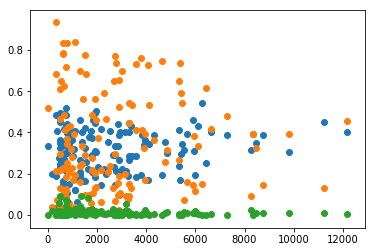

In [557]:
plt.scatter(cases, shrub)
plt.scatter(cases, forest)
plt.scatter(cases, agr)

In [27]:
valid_df['Stname']=='Massachusetts'

NameError: name 'valid_df' is not defined

In [ ]:
fips = valid_df['FIPS'].unique()

error_baseline = []
error_model= []
error_model_rf= []

# this is good, because we are not including the climate data 

for fip in fips: 
    temp = inpdf[inpdf['FIPS']==fip]
    temp_train = temp[temp['YR']<2015]
    temp_test = temp[temp['YR']==2015]
    X_train = temp_train[['YR']].values
    y_train = temp_train[['Cases']].values
    
    X_test = temp_test[['YR']].values
    y_test = temp_test[['Cases']].values
    
    reg = LinearRegression().fit(X_train, y_train)
    
    model = RandomForestRegressor(n_estimators=10, max_features=2)
    model.fit(X_train, y_train.ravel())

    y_pred = reg.predict(X_test)
    #y_pred_rf = model.predict(X_test)
    #score_model = np.sum(np.abs(y_train - reg.predict(X_train))/len(y_train))
    #print(reg.)
    error_baseline.append(np.sum(((y_test - temp[temp['year']==2014]['Cases'].values))**2)**0.5 /len(y_train))
    error_model.append(np.sum(((y_test - y_pred))**2)**0.5)
    #error_model_rf.append(np.sum(((y_test - y_pred_rf))**2)**0.5)
    #y_pred = reg.predict(X_test)


ERROR! Session/line number was not unique in database. History logging moved to new session 913


In [ ]:
model = RandomForestRegressor(n_estimators=10, max_features=2)
model.fit(X_train, y_train.ravel())

ERROR! Session/line number was not unique in database. History logging moved to new session 914


In [ ]:
valid_df['Cases']

In [ ]:
plt.plot(inpdf['tmax_2'].mean(axis=1)

In [371]:
corr = valid_df[imp_columns].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(1)

In [189]:
# subtract the running average from the temperatures 

In [207]:
temp = inpdf[inpdf['FIPS']==fip]
temp_train = temp[temp['year']<2013]
temp_test = temp[temp['year']==2013]

X_train = temp_train[['YR','pcpn_1', 'pcpn_2', 'pcpn_3','tmpc_1', 'tmpc_2', 'tmpc_3','tmin_1', 'tmin_2', 'tmin_3','tmax_1', 'tmax_2', 'tmax_3']]
y_train = temp_train[['Cases']]

In [ ]:
For a given state, plot the correlation between the number of cases vs time and different temps vs time.
As features, keep t

In [184]:
weather_columns = ['pcpn_1', 'pcpn_2', 'pcpn_3','tmpc_1', 'tmpc_2', 'tmpc_3','tmin_1', 'tmin_2', 'tmin_3','tmax_1', 'tmax_2', 'tmax_3']

#'JAN_PCPN', 'FEB_PCPN','MAR_PCPN', 'APR_PCPN', 'MAY_PCPN', 'JUN_PCPN', 'JUL_PCPN', 'AUG_PCPN','SEP_PCPN', 'OCT_PCPN', 'NOV_PCPN', 
#'DEC_PCPN', 'JAN_TMPC', 'FEB_TMPC','MAR_TMPC', 'APR_TMPC', 'MAY_TMPC', 'JUN_TMPC', 'JUL_TMPC', 'AUG_TMPC','SEP_TMPC', 'OCT_TMPC', 
#'NOV_TMPC', 'DEC_TMPC', 'JAN_TMIN', 'FEB_TMIN','MAR_TMIN', 'APR_TMIN', 'MAY_TMIN', 'JUN_TMIN', 'JUL_TMIN', 'AUG_TMIN','SEP_TMIN', 
#'OCT_TMIN', 'NOV_TMIN', 'DEC_TMIN', 'JAN_TMAX', 'FEB_TMAX','MAR_TMAX', 'APR_TMAX', 'MAY_TMAX', 'JUN_TMAX', 'JUL_TMAX', 'AUG_TMAX',
#'SEP_TMAX', 'OCT_TMAX', 'NOV_TMAX', 'DEC_TMAX',

In [297]:
df =  inpdf[imp_columns]
yr_older = df[df['YR']==2000]
yr_old = df[df['YR']==2001]
current = df[df['YR']==2002]
yr_old.columns = [x + '_old' if x!='FIPS' else x for x in yr_old.columns ]
yr_older.columns = [x + '_older' if x!='FIPS' else x for x in yr_older.columns ]

In [142]:
total_df = current.set_index(keys='FIPS').join(yr_old.set_index(keys='FIPS')).join(yr_older.set_index(keys='FIPS'))

In [143]:
y = total_df['Cases']
X = total_df.loc[:, ~total_df.columns.isin(['Cases'])]

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(1)

#### Physically, what does Lyme disease depend on?

For all seven states analyzed, significant (p < 0.05) positive relations were found for the __correlation of early summer disease incidence with the June__ moisture index 
(Palmer Hydrological Drought Index) in the region __2__ years previously. The correlations may reflect enhanced nymph tick survival in wetter conditions.
Few significant relations were found with same-year moisture index, which suggests that moisture has a greater effect on nymph tick survival following the 
insects blood meal than before. In some states, significant correlations were observed related to warmer winter weather a year and a half prior to disease incidence,
which may have been due to higher survival and activity levels of the white-footed mouse, the main host for Lyme disease-infected ticks.
Decreased rainfall in the summer months may also decrease the amount of vegetation available for mice populations to eat in order to sustain themselves during the winter.
[11] It thus follows that a decrease in rainfall may decrease the population of the ticks’ primary host and thus reduce tick populations and Lyme disease incidence.
Temperature may also play a role in Lyme disease incidence. Schauber et al. (2005) found a positive correlation between the mean summer temperature and the rate of Lyme
disease in the northeastern United States.[10] Additionally, Subak (2003) suggests that there may also be a relationship between warmer winters and increased Lyme disease.
[9] This study discovered a tentative link between warmer winter weather lagged one year and Lyme disease incidence.[9] 
Ticks seek hosts only at temperatures above 7 °C 

In [152]:
## this is a short time series prediction 
## We use the total number of cases + physical interpretation to figure out the most important cases
## Check for correlations based on previous factors
## Cant do test-train prediction, must be a time series. 
## show that it is better than previous models. 

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X, y)
y_pred = reg.predict(X_test)

In [127]:
corr = total_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(1)

In [ ]:
for year in range(2002, 2015): 
    y = ncases
    x = ncasesy-1, ncasesy-2, lat, long, temp, weather, current year, + year -1 + year -2 + forest